## Time to get your hands dirty.  The transient Universe


Let's go back to our previous example on the astrophysical transient.


8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data?

--------
## My implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dynesty
from dynesty import plotting as dyplot
import scipy
import corner

### Data

(100, 3)


Text(0.5, 0, 'time')

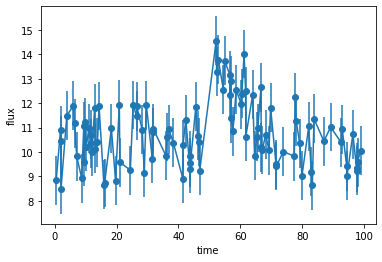

In [2]:
# data acquisition
path = '/Users/giuliamariaborro/box/reps/astrostatistics_bicocca_2022/solutions/'
data = np.load(path + 'transient.npy')
print(data.shape)

time = data[:,0]
flux = data[:,1]
eflux = data[:,2]

# plot the data with uncertainties
plt.scatter(time, flux)
plt.errorbar(time, flux, yerr = eflux)
plt.ylabel('flux')
plt.xlabel('time')

## Nested Sampling with dynesty

### Burst Model

In [3]:
#Model
def burst(par, t):
    b, A, alpha, to = par 
    return np.where(t < to, b, b + A * np.exp(-alpha*(t-to)))  # shortcut for 'if t<to return b, else return b+...'

In [4]:
# problem dimensionality
ndim = 4

#prior
def priorBurst(u):    
     
    # prior transformation
    b, A = u[0:2]*50           # A, b from uniform(0,50)    
    to = u[2]*100              # to from uniform(0,100)    
    alpha = scipy.stats.loguniform.ppf(u[3], np.exp(-5), np.exp(5))     # ln(alpha) from uniform(-5, 5)
    
    par = np.array([b, A, alpha, to])   
    return(par)


#likelihood
def loglikeBurst(par):
    x, y, erry = data.T
    My = burst(par, x)
    return - 0.5 * np.sum((y-My)**2/(erry**2)) 

In [5]:
scipy.stats.loguniform.ppf(0, np.exp(-5), np.exp(5))

0.006737946999085467

In [6]:
samplerBurst = dynesty.NestedSampler(loglikeBurst, priorBurst, ndim)
samplerBurst.run_nested()
resultsBurst = samplerBurst.results

/var/folders/l6/xx2lbds11l37fqdhf3bcglx80000gn/T/ipykernel_17107/3893424277.py:4: RuntimeWarning: overflow encountered in exp
  return np.where(t < to, b, b + A * np.exp(-alpha*(t-to)))  # shortcut for 'if t<to return b, else return b+...'
/var/folders/l6/xx2lbds11l37fqdhf3bcglx80000gn/T/ipykernel_17107/3893424277.py:4: RuntimeWarning: overflow encountered in multiply
  return np.where(t < to, b, b + A * np.exp(-alpha*(t-to)))  # shortcut for 'if t<to return b, else return b+...'
1865it [00:07, 83.37it/s, bound: 0 | nc: 41 | ncall: 18641 | eff(%): 10.005 | loglstar:   -inf < -177.227 <    inf | logz: -186.056 +/-  0.127 | dlogz: 125.664 >  0.509]     /var/folders/l6/xx2lbds11l37fqdhf3bcglx80000gn/T/ipykernel_17107/3893424277.py:4: RuntimeWarning: overflow encountered in exp
  return np.where(t < to, b, b + A * np.exp(-alpha*(t-to)))  # shortcut for 'if t<to return b, else return b+...'
1874it [00:07, 46.12it/s, bound: 1 | nc: 1 | ncall: 18777 | eff(%):  9.980 | loglstar:   -inf < -175.

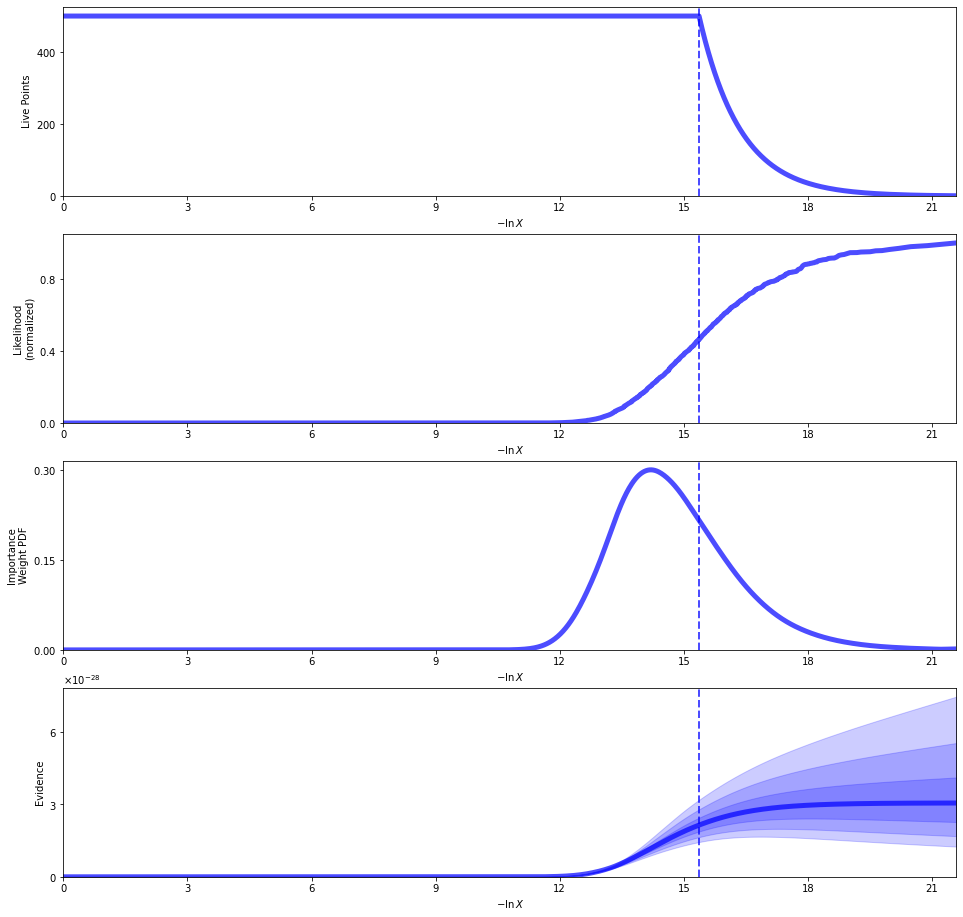

In [7]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(resultsBurst)

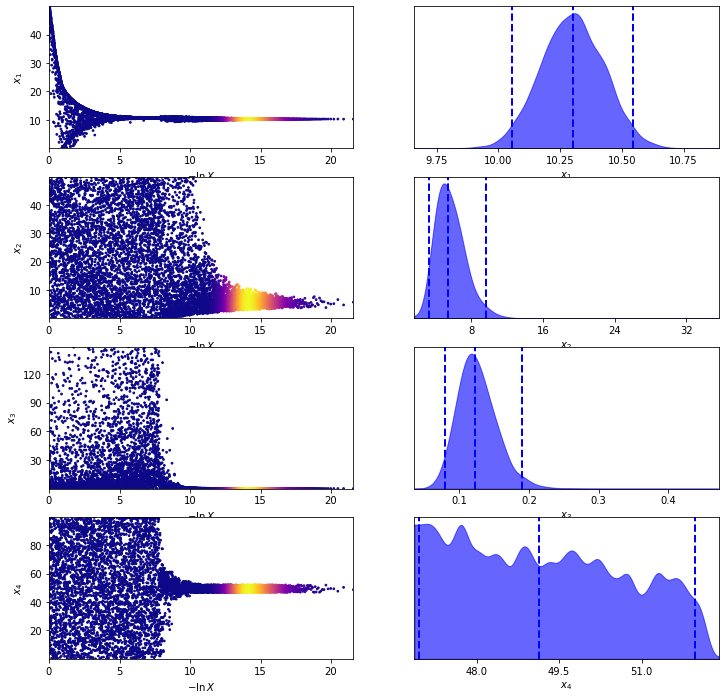

In [8]:
tfig, taxes = dyplot.traceplot(resultsBurst)

In [9]:
resultsBurst.keys()

['nlive',
 'niter',
 'ncall',
 'eff',
 'samples',
 'blob',
 'samples_id',
 'samples_it',
 'samples_u',
 'logwt',
 'logl',
 'logvol',
 'logz',
 'logzerr',
 'information',
 'bound',
 'bound_iter',
 'samples_bound',
 'scale']

In [12]:
# Extract samples
samples = resultsBurst.samples
print(samples.shape)


#cumulative evidence
cumevidenceBurst = np.exp(resultsBurst.logz)   
#print(cumevidence.shape, cumevidence)


# weight (unnormalized) associated to each sample
weights = np.exp(resultsBurst.logwt)   
weights /= cumevidenceBurst[-1]  #normalized now


#resample the run so that all points have equal weight
sampleBurst = dynesty.utils.resample_equal(samples, weights)

(8191, 4)


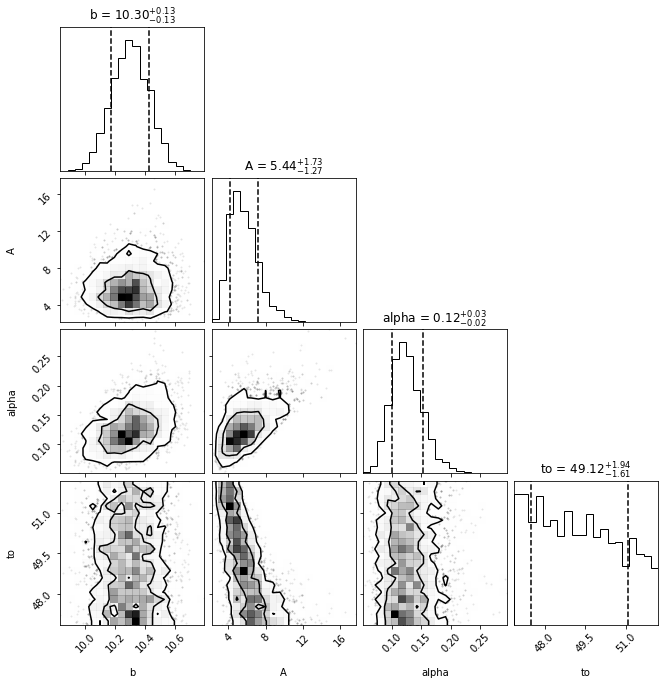

In [13]:
corner.corner(sampleBurst, labels=['b', 'A', 'alpha','to'], 
            levels = [0.68, 0.95], quantiles=[0.16, 0.84],
            show_titles=True);

### Gaussian model

Try to fit data with the Gaussian model:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

In [14]:
# Model Gaussian
def GaussFlux(par, t):
    A, b, to, sigma = par     
    return b+A*np.exp(-(((t-to)/sigma)**2 ) / 2)


In [15]:
# prior transformation: start with uniform prior
def priorGauss(u):    
    
    # prior transformation
    b, A = u[0:2]*50           # A, b from uniform(0,50)    
    to = u[2]*100              # to from uniform(0,100)    
    sigma = scipy.stats.loguniform.ppf(u[3], np.exp(-3), np.exp(3))  # ln(sigma) from uniform(-5, 5)
    
    par = np.array([b, A, to, sigma])
    
    return(par)


#likelihood
def loglikeGauss(par):
    x, y, erry = data.T
    My = GaussFlux(par, x)
    return -0.5 * np.sum((y-My)**2 / erry**2 )

In [16]:
samplerGauss = dynesty.NestedSampler(loglikeGauss, priorGauss, ndim)

In [17]:
samplerGauss.run_nested()
resultsGauss = samplerGauss.results

8393it [02:06, 66.45it/s, +500 | bound: 125 | nc: 1 | ncall: 118890 | eff(%):  7.512 | loglstar:   -inf < -52.443 <    inf | logz: -68.501 +/-  0.179 | dlogz:  0.001 >  0.509]


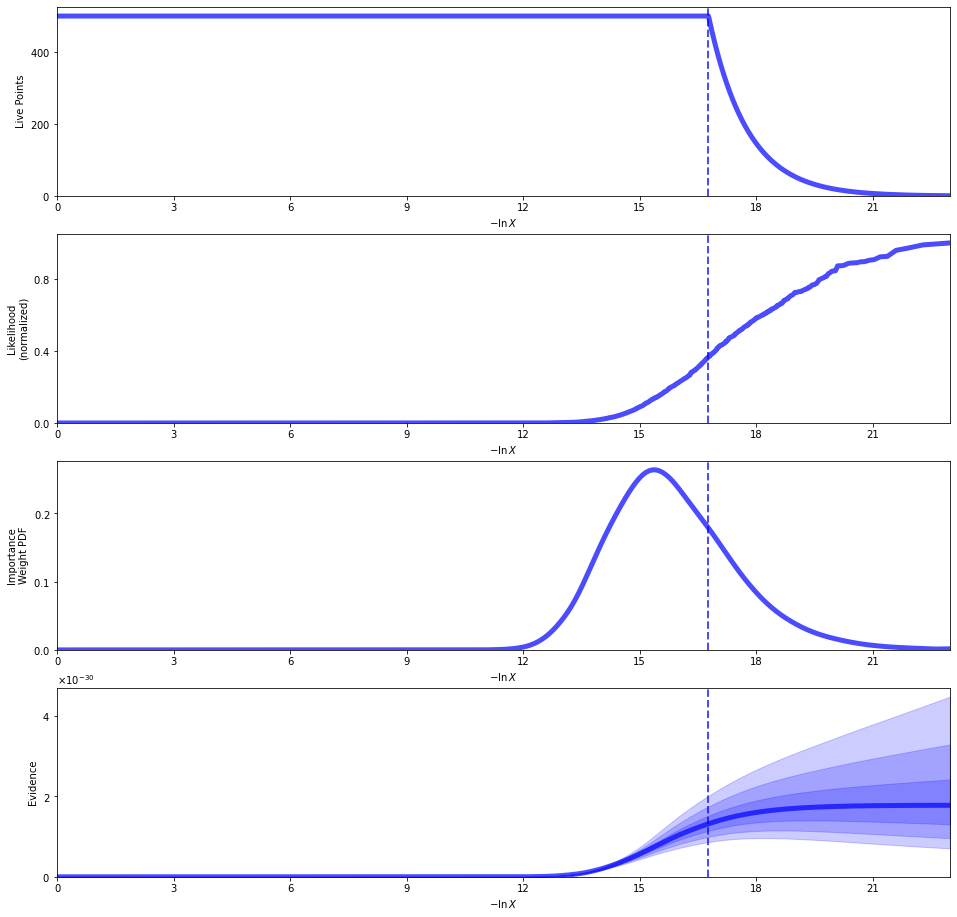

In [18]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(resultsGauss)

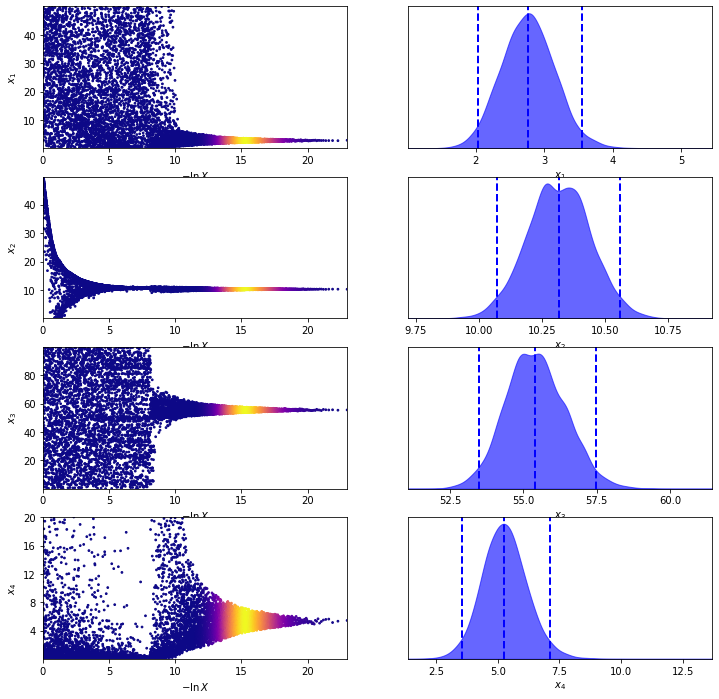

In [19]:
tfig, taxes = dyplot.traceplot(resultsGauss)

In [20]:
# Extract samples
samples = resultsGauss.samples
print(samples.shape)

#cumulative evidence
cumevidenceGauss= np.exp(resultsGauss.logz)
#print(cumevidence.shape, cumevidence)

# weight (not normalized) associated to each sample
weights = np.exp(resultsGauss.logwt)
weights /= cumevidenceGauss[-1]   #normalize
print(weights.shape)

#resample the run so that all points have equal weight
samplesGauss = dynesty.utils.resample_equal(samples, weights)

(8893, 4)
(8893,)


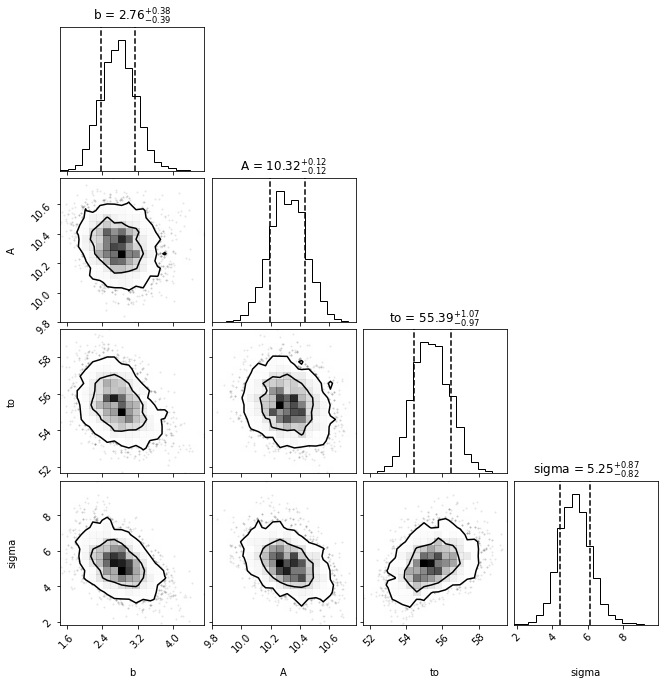

In [21]:
corner.corner(samplesGauss, labels=['b', 'A', 'to','sigma'], 
            levels = [0.68, 0.95], quantiles=[0.16, 0.84],
            show_titles=True);

### Model comparison

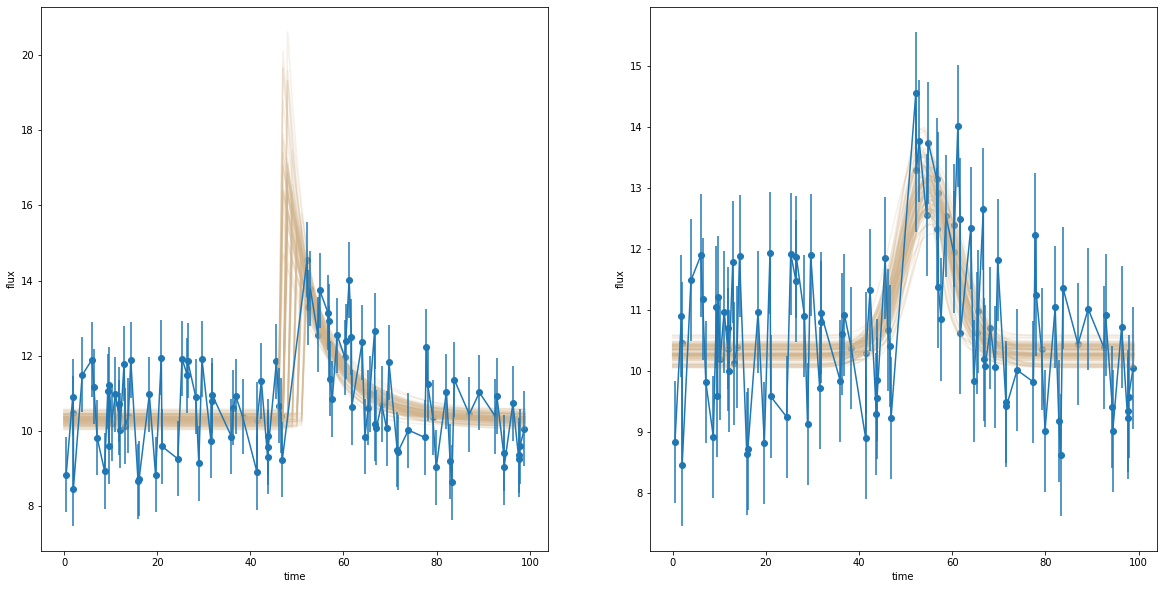

In [40]:
Burst100 = sampleBurst[np.random.choice(range(len(sampleBurst )), 100)]
Gauss100 = samplesGauss[np.random.choice(range(len(samplesGauss )), 100)]
t = np.linspace(0,100,100)

fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(121)
for i in range(len(Burst100)):
    yfit = burst(Burst100[i], t)
    plt.plot(yfit, color='tan', alpha=0.2)    #posterior spread of model solutions consistent with data
    
plt.scatter(time, flux)
plt.errorbar(time, flux, yerr = eflux)
plt.ylabel('flux')
plt.xlabel('time')

ax2 = fig.add_subplot(122)
for i in range(len(Gauss100)):
    yfit = GaussFlux(Gauss100[i], t)
    plt.plot(yfit, color='tan', alpha=0.2)    #posterior spread of model solutions consistent with data
    
plt.scatter(time, flux)
plt.errorbar(time, flux, yerr = eflux)
plt.ylabel('flux')
plt.xlabel('time');

Compute Bayes factor to compare models

In [20]:
BayesFactor =  cumevidenceBurst[-1]/cumevidenceGauss[-1]
print(BayesFactor)

181.57341569164032


burst model fits much better than the Gaussian!

----------